In [46]:
%load_ext autoreload
%autoreload 2

# Import libraries
import copy
import os
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np

from vnc_networks import MANC, CMatrix, Connections, Neuron, params
from vnc_networks.specific_neurons import dn_helper
from vnc_networks.specific_neurons import motor_neurons_helper as mns_helper
from vnc_networks.utils import matrix_design, plots_design


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# ----- Directories
DN_name = "DNa06" 
manc_version = "v1.2"
DN_DIR = f"{DN_name}_plots"
FIG_DIR = MANC(manc_version).get_fig_dir()
DN_FIGS = os.path.join(FIG_DIR, DN_DIR)
os.makedirs(DN_FIGS, exist_ok=True)

In [48]:
savefigs = True # True if you want to save the figures

# Part 1A: Independence of leg circuits

### 1Aa Create a connectome with MDNs split by neuropil

In [49]:
CR = MANC(manc_version)
split_dn_vnc = dn_helper.get_vnc_split_DNs_by_neuropil(
        not_connected=dn_helper.get_dn_bodyids(name=DN_name),
        name=DN_name,
    )

Loaded VNC Connections object with DNa06s split by neuropil.


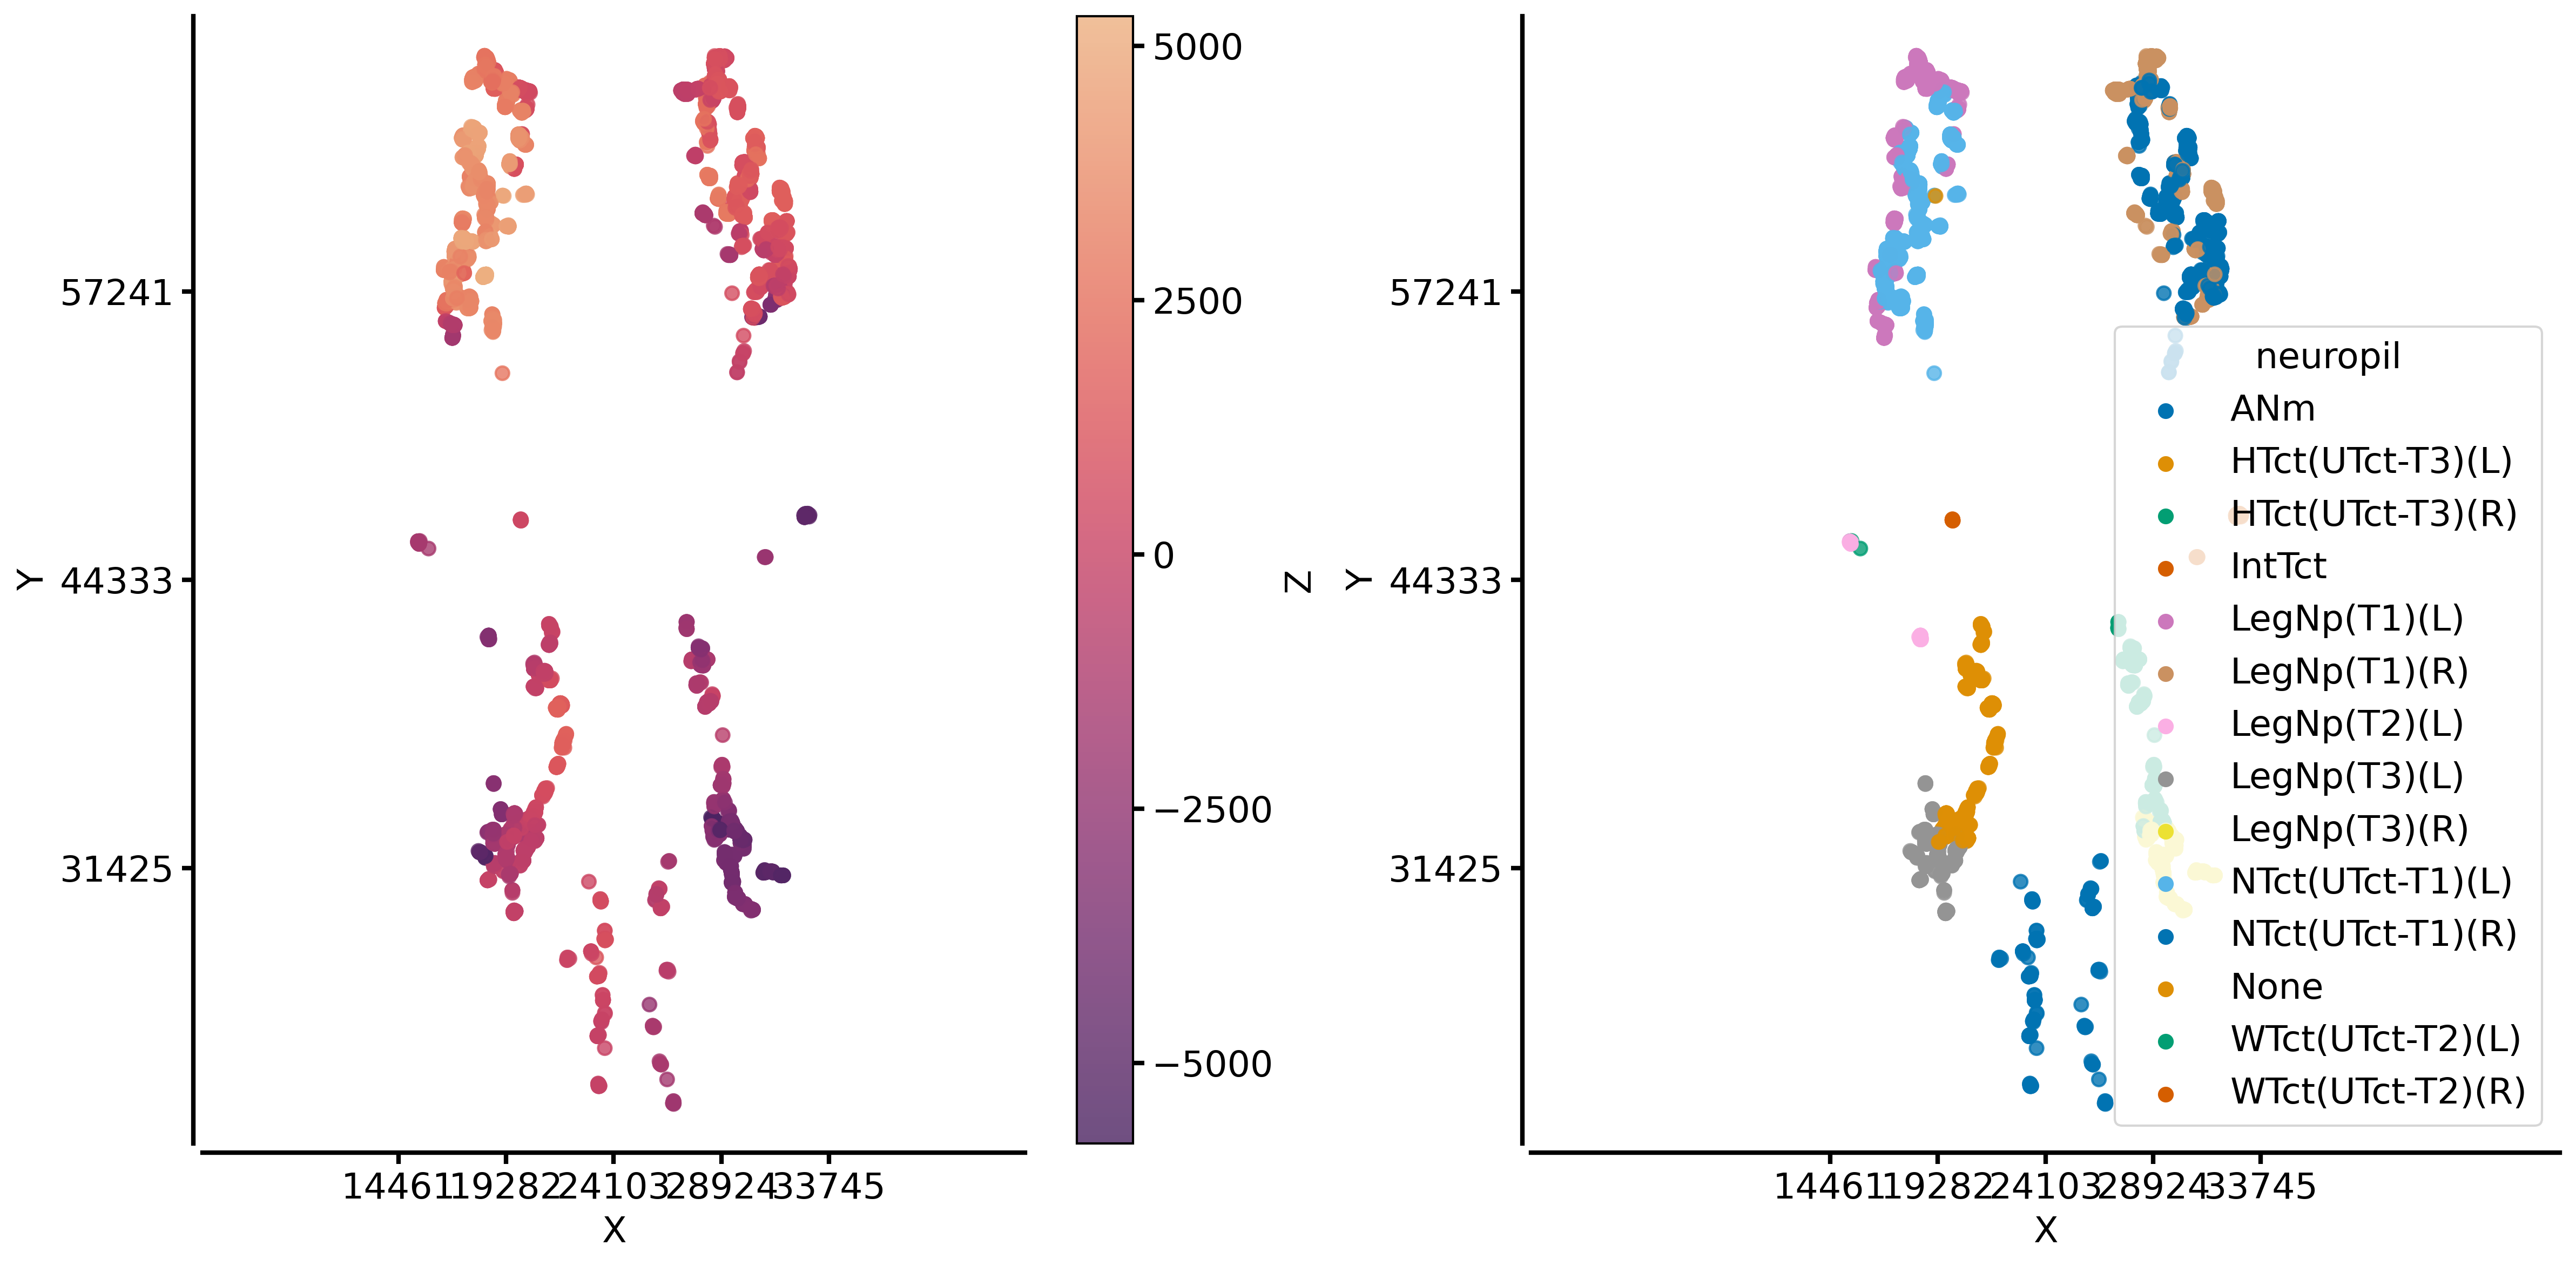

In [50]:
# Verify that the synapse distribution for the DNs makes sense
dn_bids = CR.get_neuron_bodyids({"type": DN_name})
dns = [
    Neuron(from_file=f'neuron-{bid}_neuropil-split', CR=CR)
    for bid in dn_bids
]
# Figure: synapse distribution, left: depth coloured, right: neuropil colored
angle = -60 # angle of the neuropil display
X1, Y1, Z1 = [],[],[]
X2, Y2, Z2 = [],[],[]
for dn in dns:
    x1, y1, z1 = dn.get_synapse_distribution(angle=angle)
    x2, y2, z2 = dn.get_synapse_distribution(z_attribute="neuropil", angle=angle)
    X1.extend(x1)
    Y1.extend(y1)
    Z1.extend(z1)
    X2.extend(x2)
    Y2.extend(y2)
    Z2.extend(z2)

fig, axs = plt.subplots(
    1,
    2,
    figsize=(2*params.FIG_WIDTH, params.FIG_HEIGHT),
    dpi=params.DPI
    )
plots_design.scatter_xyz_2d(
    X1, Y1, Z=Z1,
    ax=axs[0],
    cmap=params.r_red_colorscale
    )
axs[0].axis('equal')
plots_design.scatter_xyz_2d(
    X2,
    Y2,
    Z=Z2,
    z_label="neuropil",
    discrete_coloring=True,
    ax=axs[1],
    cmap=params.colorblind_palette,
)
axs[1].axis("equal")

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(DN_FIGS, f"{DN_name}_synapse_distribution.pdf"))
    plt.savefig(os.path.join(DN_FIGS, f"{DN_name}_synapse_distribution.png"))

plt.show()

### 1Ab Connectivity between DN sets and motor neurons

In [51]:
def confusion_matrix_dn_to_mn(
        connections: Connections,
        n_hops: int = 2,
        dn_name: str = DN_name,
    ):
    """
    Create a confusion matrix of the number of connections from DN to motor
    neurons within n hops, where the rows are the DNs split by neuropil and
    the columns are the motor neurons split by leg.
    """
    legs = ["f", "m", "h"]
    sides = ["R", "L"]
    dn_uids = [] # 3 x 2 list of lists
    for leg in legs:
        for side in sides:
            dn_uids.append(
                dn_helper.get_subdivided_dns(
                    connections, neuropil=leg, side=side, name=dn_name
                )
            )
        
    # Get the uids of motor neurons split by leg
    list_motor_neurons = []
    for leg in legs:
        for side in sides:
            leg_motor_neurons = list(
                mns_helper.get_leg_motor_neurons(connections, leg=leg, side=side)
            )
            list_motor_neurons.append(leg_motor_neurons)

    # Get the summed connection strength up to n hops
    eff_weight_abs = connections.get_cmatrix(type_="norm")
    eff_weight_abs.absolute()
    eff_weight_abs.within_power_n(n_hops)

    # Get the confusion matrix
    confusion_matrix = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            mat = copy.deepcopy(eff_weight_abs)
            if len(dn_uids[i]) == 0:
                confusion_matrix[i, j] = np.nan
                print(f"DN {i} has no uids")
            else:
                mat.restrict_from_to(
                    row_ids=dn_uids[i],
                    column_ids=list_motor_neurons[j],
                    input_type="uid",
                )
                matrix = mat.get_matrix()
                confusion_matrix[i, j] = matrix.sum()

    return confusion_matrix

def plot_confusion_matrix_dn_to_mn(
        confusion_matrix: np.ndarray,
        ax: Optional[plt.Axes] = None,
        side: Optional[str] = None,
        dn_name: str = DN_name,
    ):
    """
    Plot the confusion matrix of the number of connections from DN to motor
    neurons within n hops, where the rows are the DNs split by neuropil and
    the columns are the motor neurons split by leg.
    """
    if side is None: # bilateral plot
        # Plot the confusion matrix
        ax = matrix_design.imshow(
            confusion_matrix,
            ylabel=f"{dn_name} subdivision",
            row_labels=["T1_R", "T1_L", "T2_R", "T2_L", "T3_R", "T3_L"],
            xlabel="leg motor neuron",
            col_labels=["f_R", "f_L", "m_R", "m_L", "h_R", "h_L"],
            title=f"Confusion matrix of {dn_name} to MN connections",
            cmap=params.grey_heatmap,
            vmin=0,
            ax=ax,
        )
    else: # unilateral plot
        row_labels = ["T1", "T2", "T3"]
        col_labels = ["f", "m", "h"]
        if side == "L":
            mat = confusion_matrix[1::2, 1::2]
            title = f"Confusion matrix of {dn_name} to MN connections (left)"
        elif side == "R":
            mat = confusion_matrix[0::2, 0::2]
            title = f"Confusion matrix of {dn_name} to MN connections (right)"
        else:
            raise ValueError("side must be either 'L' or 'R'")
        # Plot the confusion matrix
        ax = matrix_design.imshow(
            mat,
            ylabel=f"{dn_name} subdivision",
            row_labels=row_labels,
            xlabel="leg motor neuron",
            col_labels=col_labels,
            title=title,
            cmap=params.grey_heatmap,
            vmin=0,
            ax=ax,
        )
    return ax


DN 2 has no uids
DN 2 has no uids
DN 2 has no uids
DN 2 has no uids
DN 2 has no uids
DN 2 has no uids


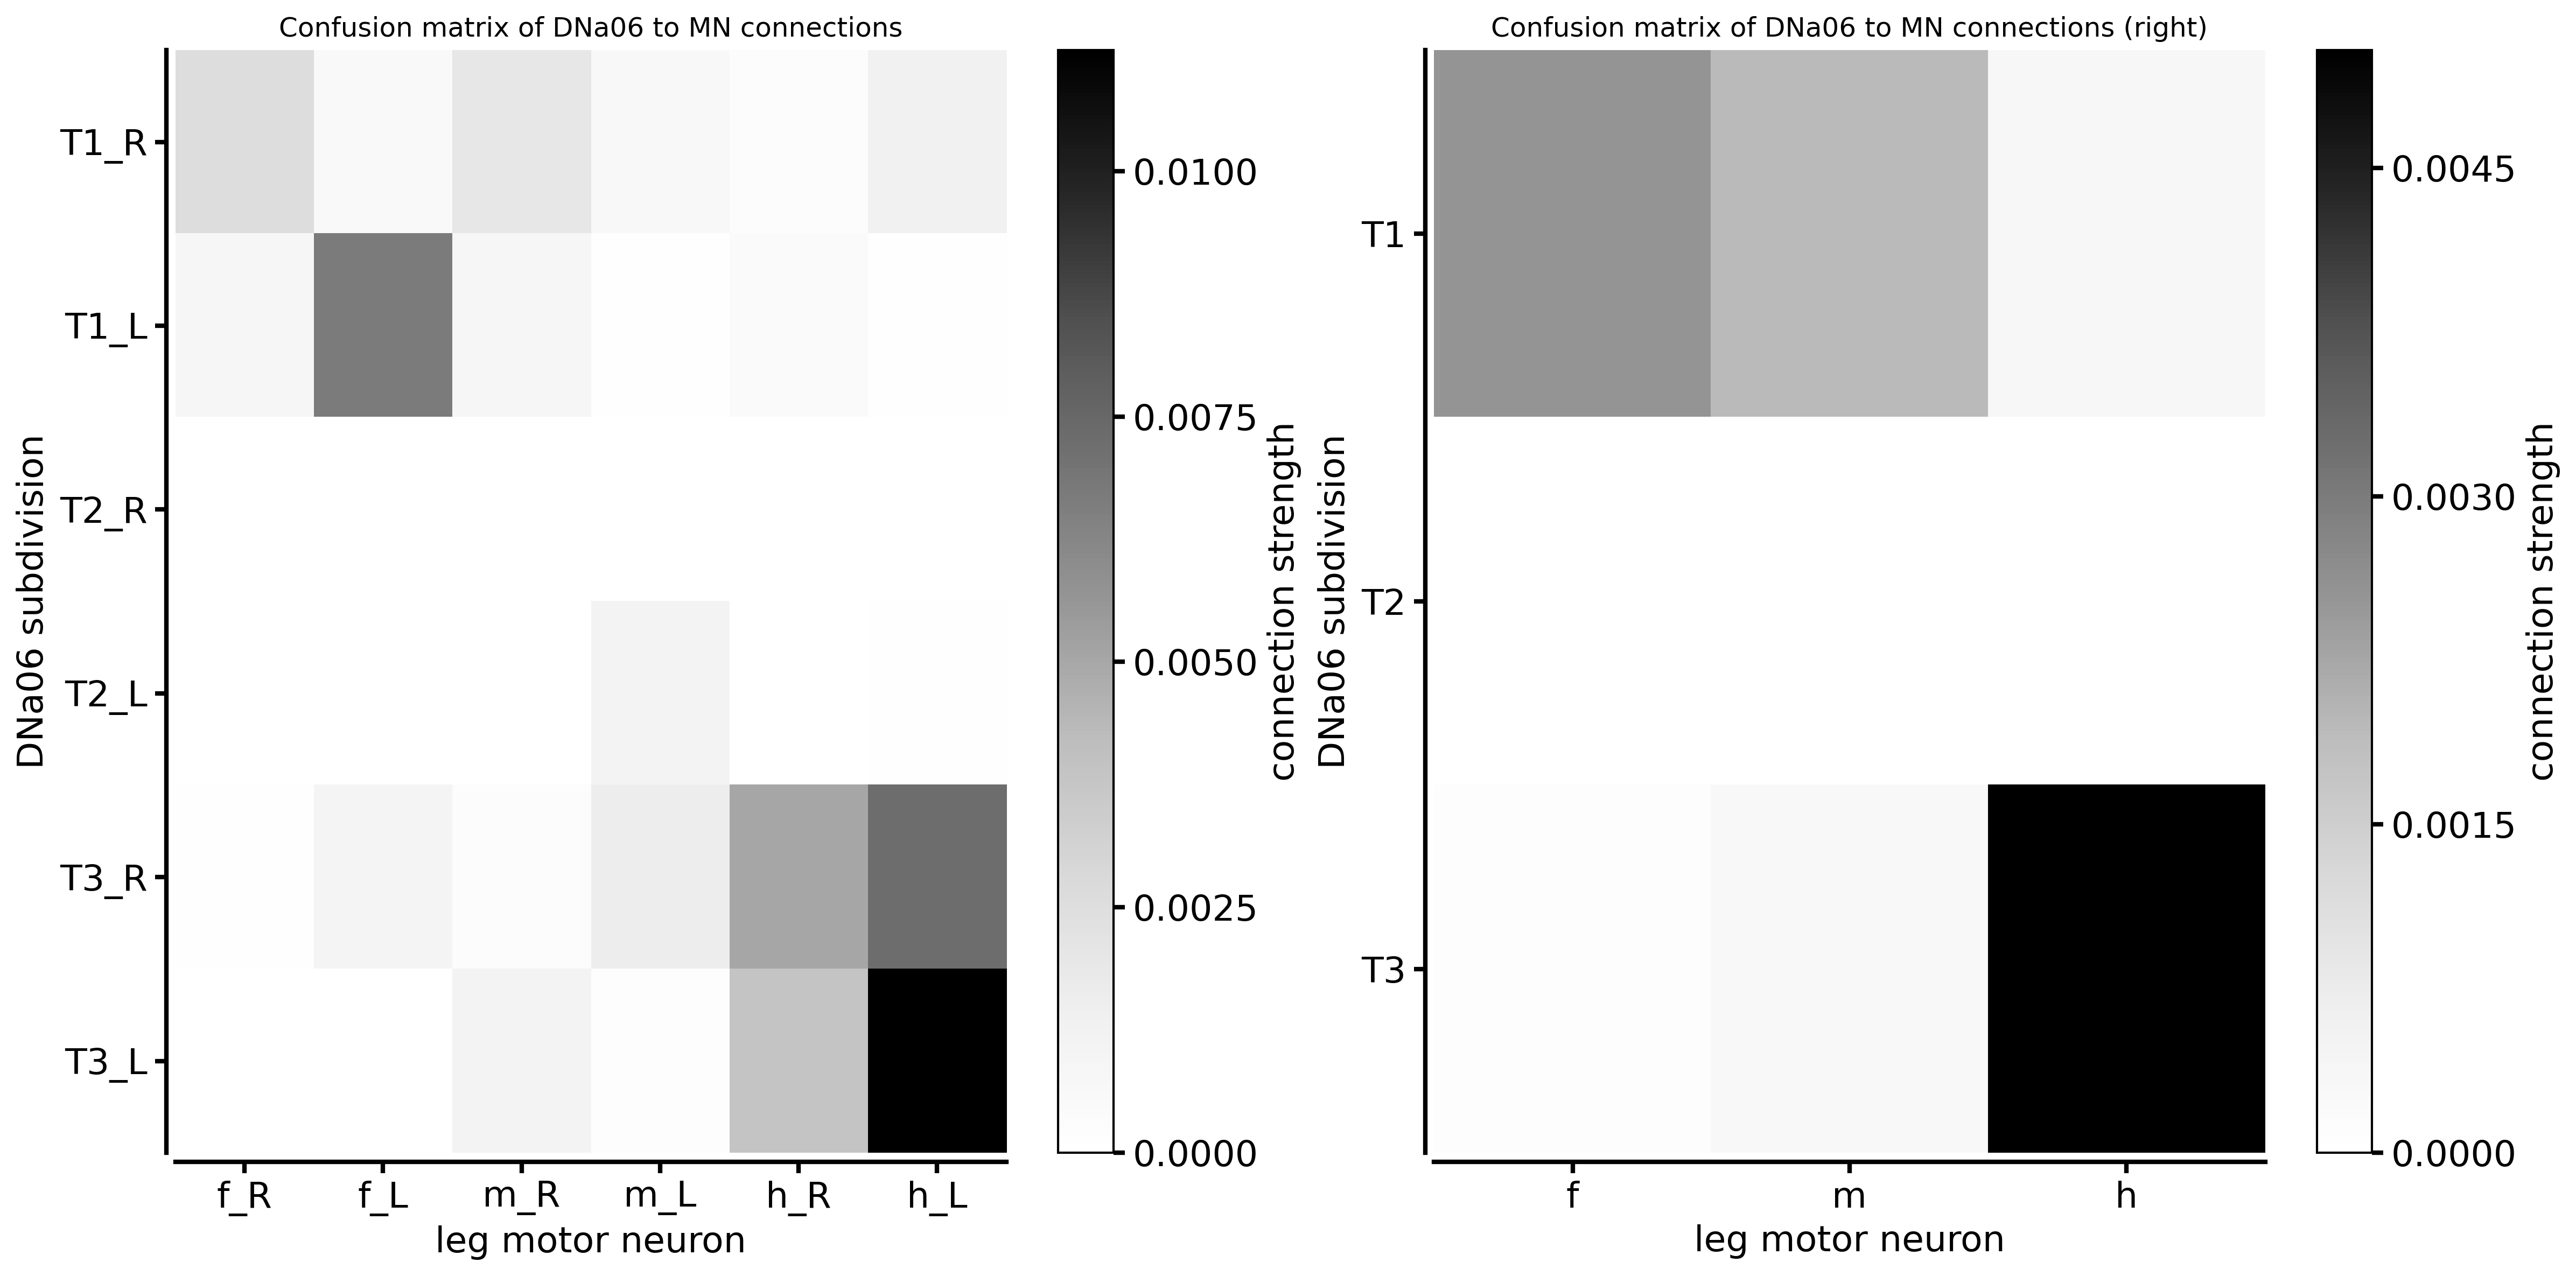

In [52]:
conf_mat = confusion_matrix_dn_to_mn(
    connections=split_dn_vnc,
    n_hops=2,
    dn_name=DN_name,
)
# Plotting
fig, axs = plt.subplots(
    1,
    2,
    figsize=(2*params.FIG_WIDTH, params.FIG_HEIGHT),
    dpi=params.DPI
)
axs[0] = plot_confusion_matrix_dn_to_mn(
    confusion_matrix=conf_mat,
    ax=axs[0],
    dn_name=DN_name,
)
axs[1] = plot_confusion_matrix_dn_to_mn(
    confusion_matrix=conf_mat,
    ax=axs[1],
    side="R",
    dn_name=DN_name,
)
if savefigs:
    plt.savefig(os.path.join(DN_FIGS, f"{DN_name}_to_MN_confusion_matrix.pdf"))
    plt.savefig(os.path.join(DN_FIGS, f"{DN_name}_to_MN_confusion_matrix.png"))
plt.show()


DN 2 has no uids
DN 2 has no uids
DN 2 has no uids
DN 2 has no uids
DN 2 has no uids
DN 2 has no uids


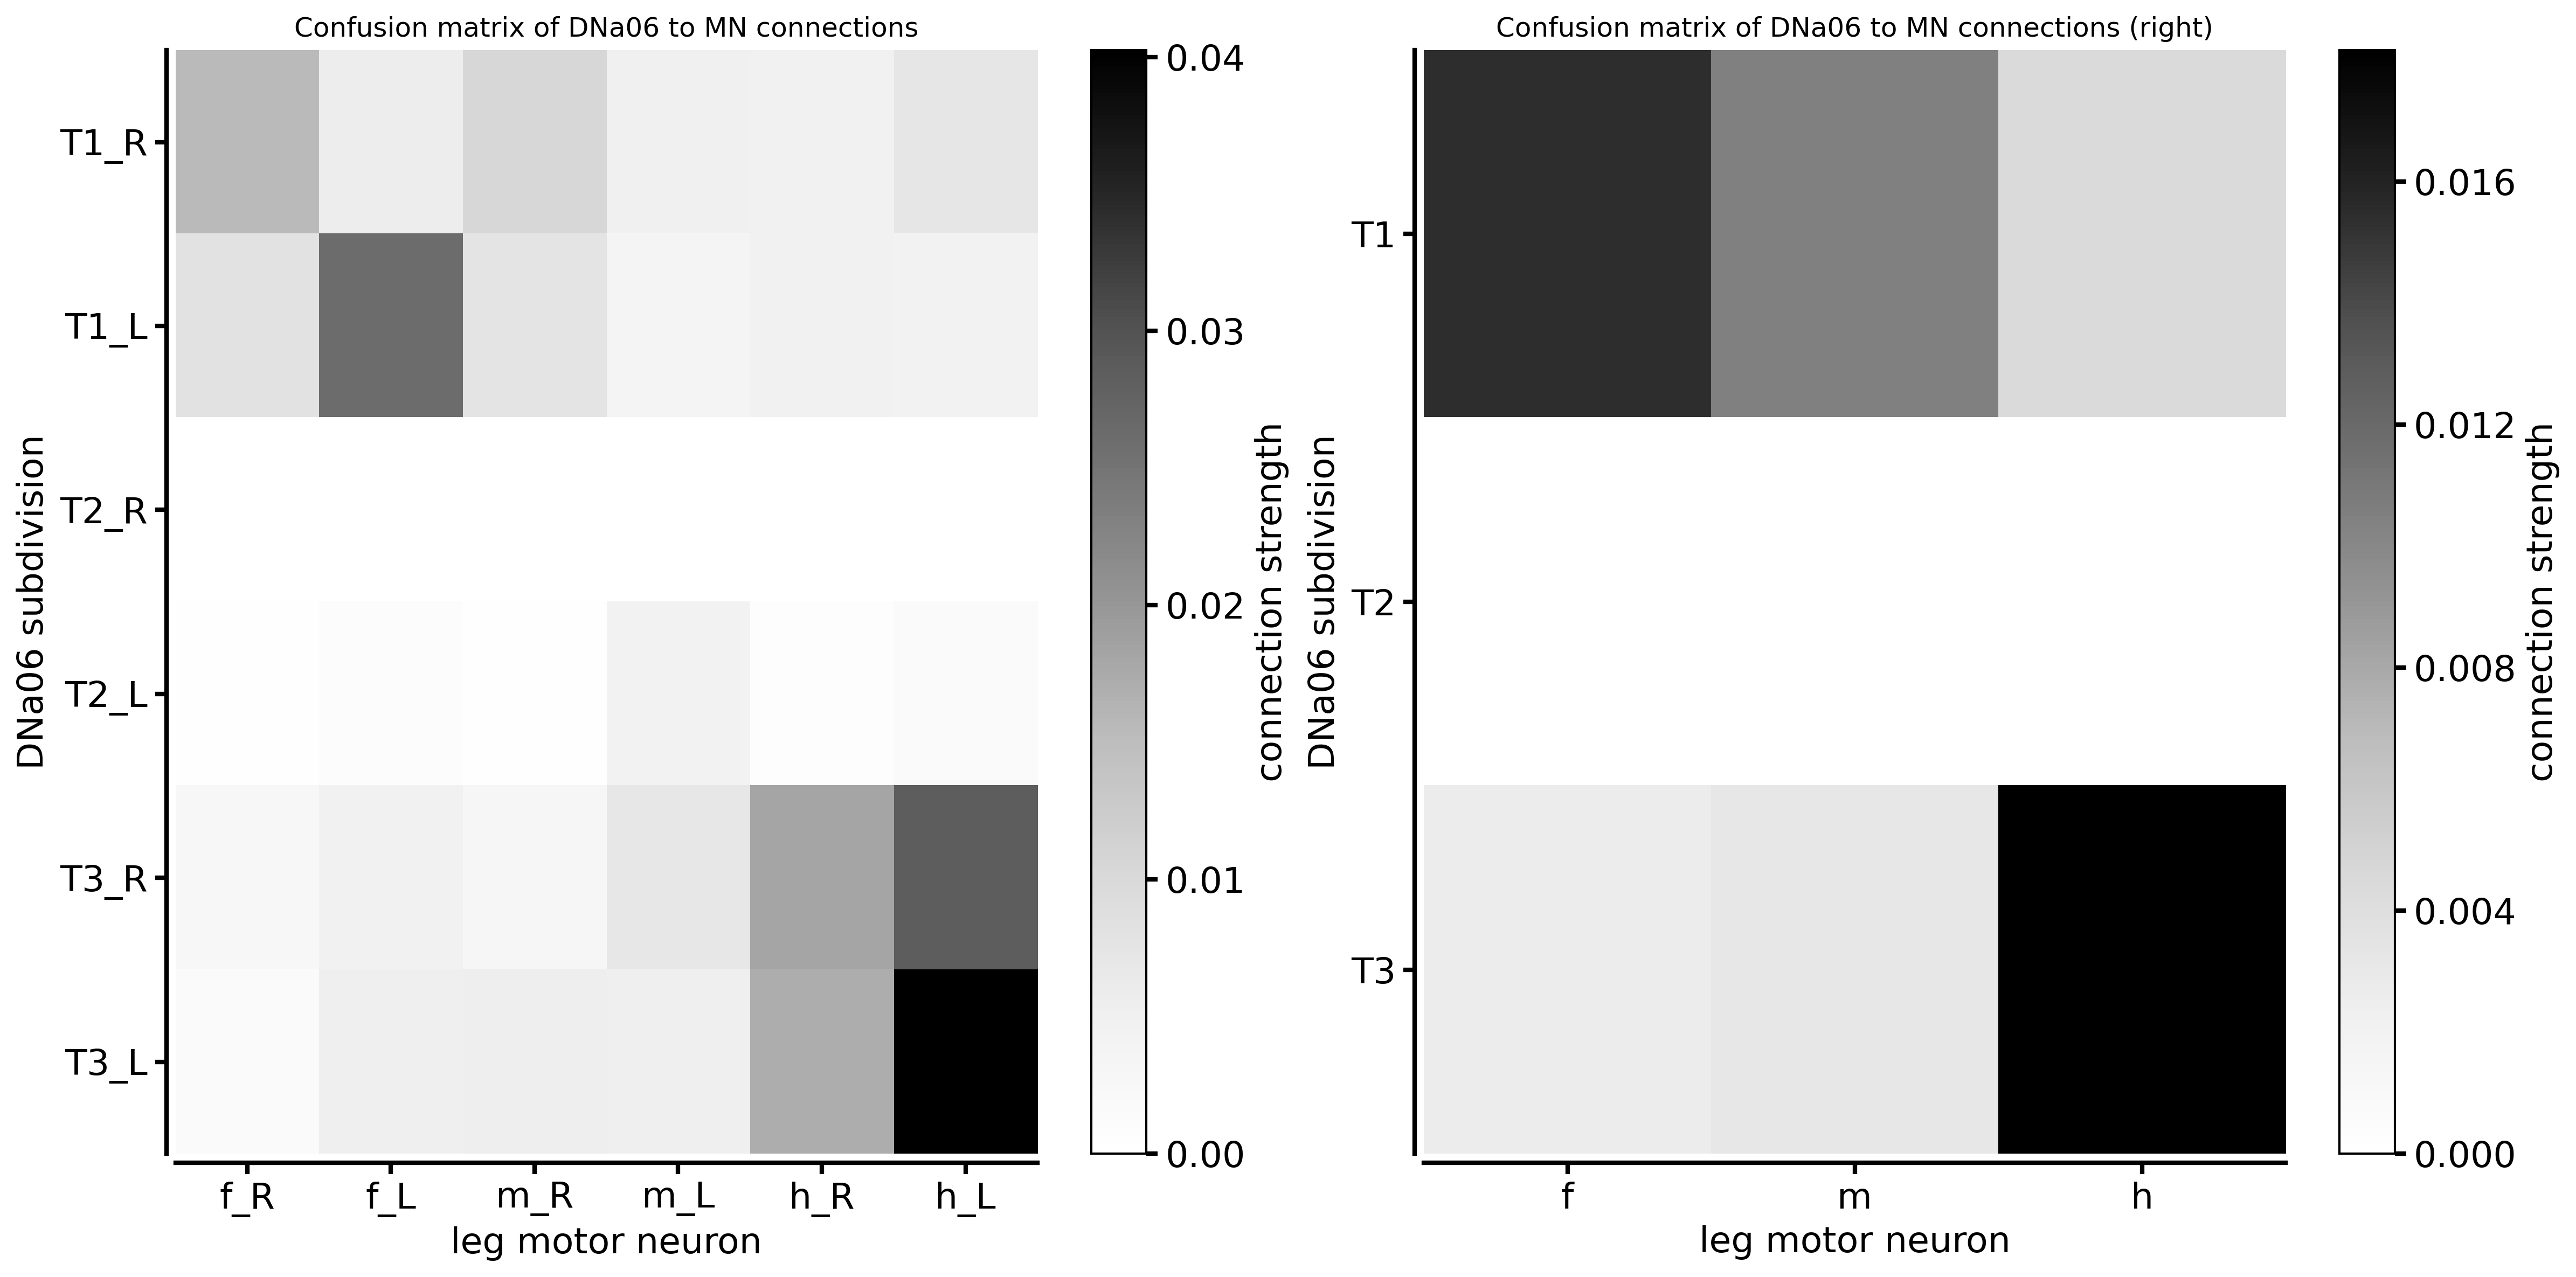

In [53]:
conf_mat = confusion_matrix_dn_to_mn(
    connections=split_dn_vnc,
    n_hops=4,
    dn_name=DN_name,
)
# Plotting
fig, axs = plt.subplots(
    1, 2, figsize=(2 * params.FIG_WIDTH, params.FIG_HEIGHT), dpi=params.DPI
)
axs[0] = plot_confusion_matrix_dn_to_mn(
    confusion_matrix=conf_mat,
    ax=axs[0],
    dn_name=DN_name,
)
axs[1] = plot_confusion_matrix_dn_to_mn(
    confusion_matrix=conf_mat,
    ax=axs[1],
    side="R",
    dn_name=DN_name,
)
if savefigs:
    plt.savefig(os.path.join(DN_FIGS, f"{DN_name}_to_MN_confusion_matrix_4_hops.pdf"))
    plt.savefig(os.path.join(DN_FIGS, f"{DN_name}_to_MN_confusion_matrix_4_hops.png"))
plt.show()


# Part 1B: Movement space of DN sets

In [54]:
# List of all the muscles that can be targeted 
Unclear = [  
    "Tergopleural/Pleural promotor",
    "Pleural remotor/abductor",
    "Sternal anterior rotator",
    "Sternal posterior rotator",
    "Sternal adductor",
    "Fe reductor",
    "ltm",
    "ltm2-femur",
    "ltm1-tibia",
]
Extensors = [
    "Tergotr.",
    "Sternotrochanter",
    "Tr extensor",
    "Ti extensor",
    "Ta depressor",
]
Flexors = [
    "Tr flexor",
    "Acc. tr flexor",
    "Ti flexor",
    "Acc. ti flexor",
    "Ta levator",
]
Muscles = Extensors + Flexors + Unclear


In [55]:
def average_weight_from_dn_to_muscle(
        leg: str,
        side: str,
        muscle: str,
        connections: Connections,
        cmat: CMatrix,
        dn_name: str = DN_name,
    ):
    """
    Get the average connection strength from DN to a muscle, uising the weights
    from the connection matrix.
    """
    source = dn_helper.get_subdivided_dns(connections, neuropil=leg, side=side, name=dn_name)
    if len(source) == 0:
        return np.nan
    target = connections.get_neuron_ids(
        {
            "class_1": "motor",
            "class_2": leg,
            "target": muscle,
            "side": side,
        }
    )
    if len(target) == 0:
        return np.nan
    # Restrict the connection matrix to its relevant entries
    mat = copy.deepcopy(cmat)
    mat.restrict_from_to(
        row_ids=source,
        column_ids=target,
        input_type="uid",
    )
    matrix = mat.get_matrix()
    return matrix.mean()

In [56]:
# compute the effective connection weights for any pair of neurons
cmat_pos = split_dn_vnc.get_cmatrix(type_="norm")
cmat_neg = copy.deepcopy(cmat_pos)

cmat_pos.square_positive_paths_only() # effective excitatory connections length 2
cmat_neg.square_negative_paths_only()

In [57]:
positive_weights = np.zeros((3, len(Muscles)))

for i, neuropil in enumerate(["fl", "ml", "hl"]):
    for j, muscle in enumerate(Muscles):
        positive_weights[i, j] = average_weight_from_dn_to_muscle(
            leg=neuropil,
            side="RHS",
            muscle=muscle,
            connections=split_dn_vnc,
            cmat=cmat_pos,
        )

negative_weights = np.zeros((3, len(Muscles)))
for i, neuropil in enumerate(["fl", "ml", "hl"]):
    for j, muscle in enumerate(Muscles):
        negative_weights[i, j] = average_weight_from_dn_to_muscle(
            leg=neuropil,
            side="RHS",
            muscle=muscle,
            connections=split_dn_vnc,
            cmat=cmat_neg,
        )                 

In [58]:
max_scale = max(np.nanmax(positive_weights), abs(np.nanmin(negative_weights)))

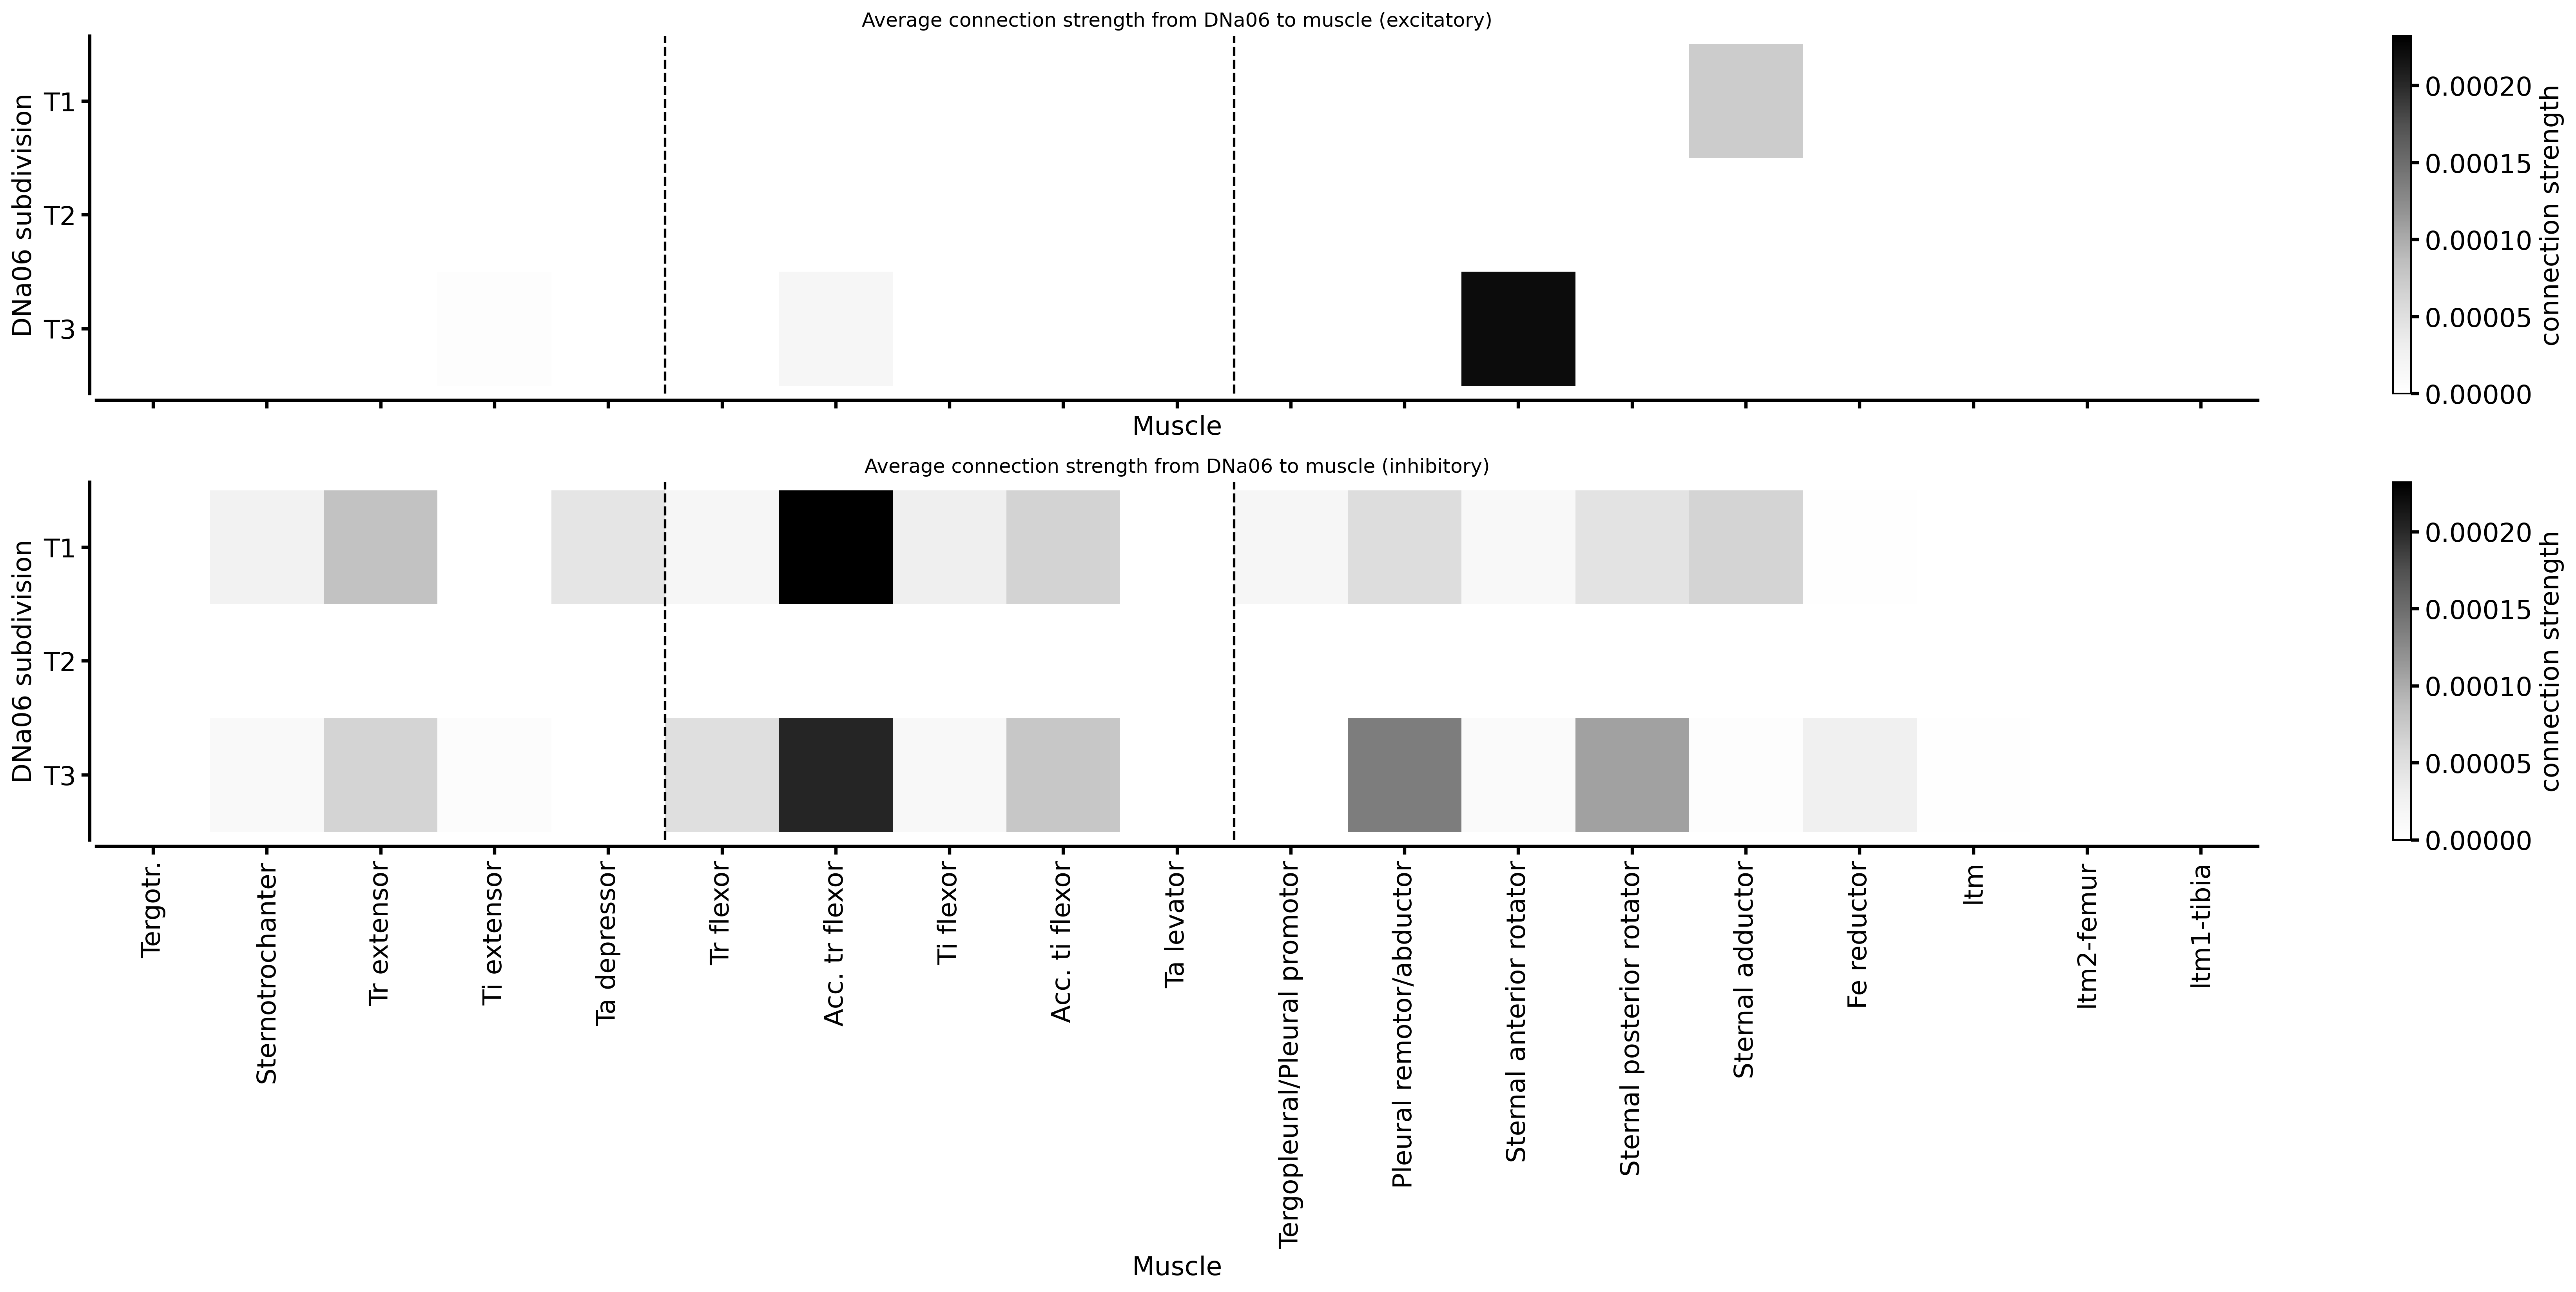

In [59]:
fig, axs = plt.subplots(
    2,
    1,
    figsize=(3*params.FIG_WIDTH, params.FIG_HEIGHT),
    dpi=params.DPI
)
vertical_marks = [len(Extensors) - 0.5, len(Extensors) + len(Flexors) - 0.5]

axs[0] = matrix_design.imshow(
    positive_weights,
    ylabel=f"{DN_name} subdivision",
    row_labels=["T1", "T2", "T3"],
    xlabel="Muscle",
    col_labels=Muscles,
    title=f"Average connection strength from {DN_name} to muscle (excitatory)",
    cmap=params.grey_heatmap,
    vmin=0,
    vmax=max_scale,
    ax=axs[0],
)
# remove x ticks
plt.setp(axs[0].get_xticklabels(), visible=False)

axs[1] = matrix_design.imshow(
    -1 * negative_weights,
    ylabel=f"{DN_name} subdivision",
    row_labels=["T1", "T2", "T3"],
    xlabel="Muscle",
    col_labels=Muscles,
    title=f"Average connection strength from {DN_name} to muscle (inhibitory)",
    cmap=params.grey_heatmap,
    vmax=max_scale,
    vmin=0,
    ax=axs[1],
)

# set axis equal
for ax in axs:
    ax.axis("equal")

for mark in vertical_marks:
    axs[0].axvline(mark, color="k", linestyle="--")
    axs[1].axvline(mark, color="k", linestyle="--")

plt.tight_layout()
plt.xticks(rotation=90)

if savefigs:
    plt.savefig(
        os.path.join(DN_FIGS, f"{DN_name}_to_muscle_connection_strength.pdf"),
        bbox_inches="tight",  # don't crop the legend
    )
    plt.savefig(
        os.path.join(DN_FIGS, f"{DN_name}_to_muscle_connection_strength.png"),
        bbox_inches="tight",  # don't crop the legend
    )

plt.show()

/home/hurtak/multi_connectomes/vnc_networks/vnc_networks/utils/matrix_design.py:66: RuntimeWarning: All-NaN axis encountered
  vmax = max(abs(np.nanmin(matrix_)), np.nanmax(matrix_))


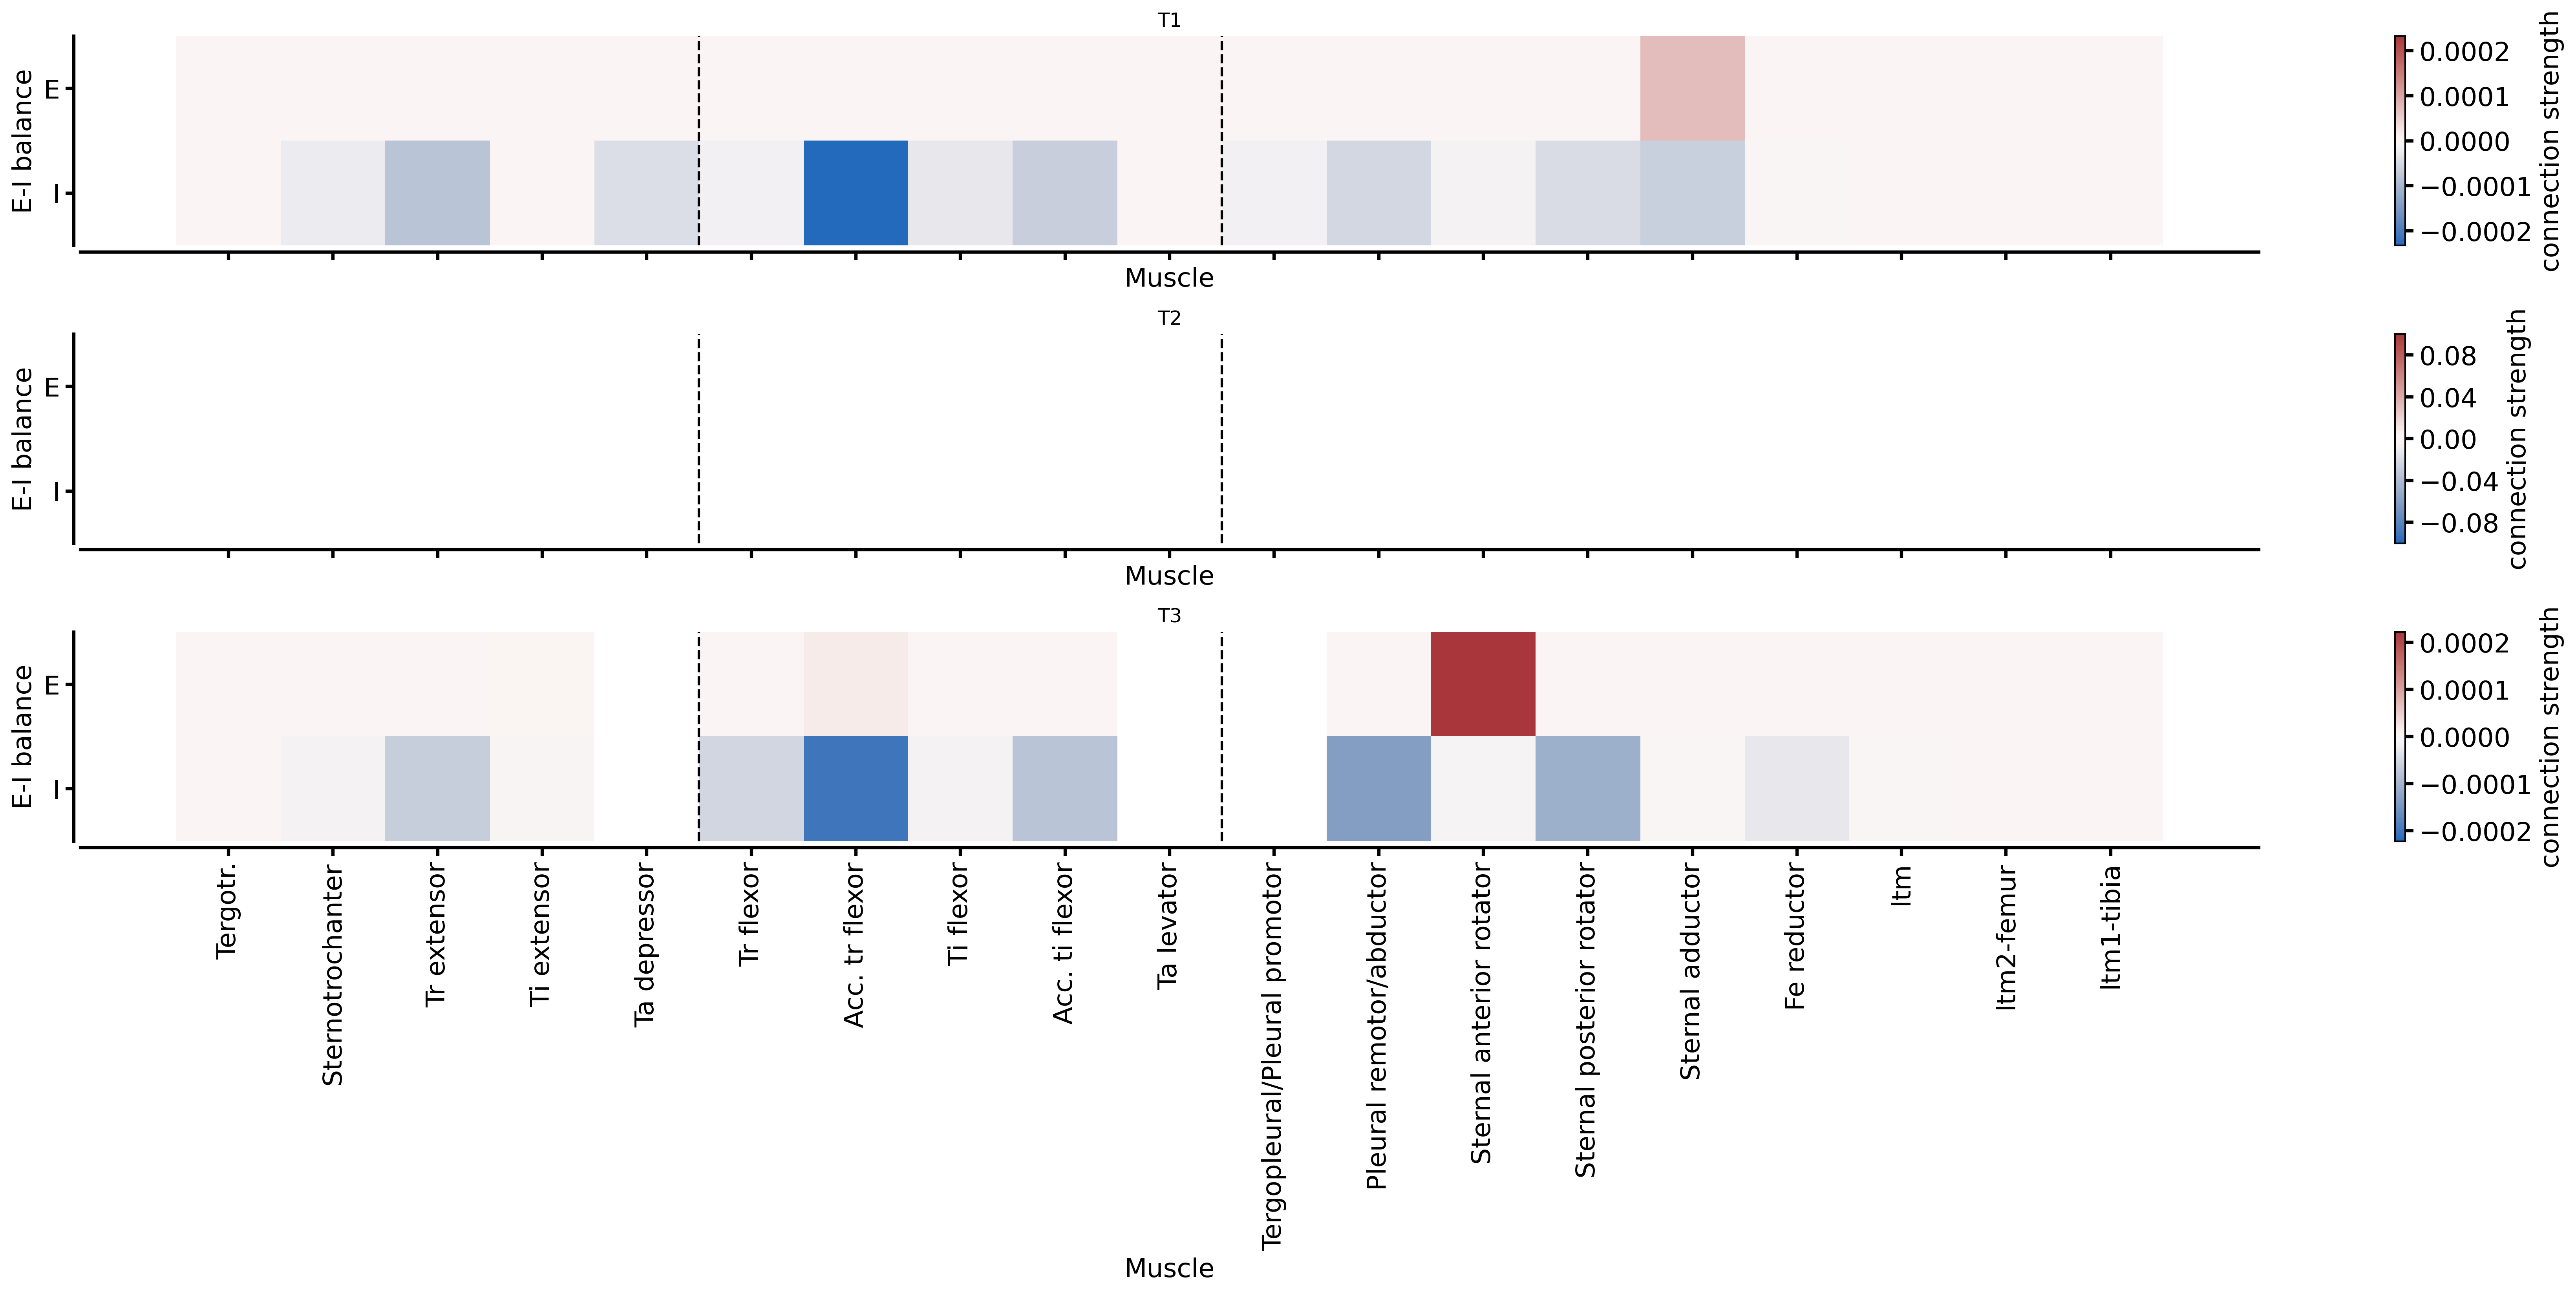

In [60]:
# Highlight the differences in excitation and inhibition for a given neuropil
fig, axs = plt.subplots(
    3, 1, figsize=(3 * params.FIG_WIDTH, params.FIG_HEIGHT), dpi=params.DPI
)
vertical_marks = [len(Extensors) - 0.5, len(Extensors) + len(Flexors) - 0.5]

T1 = [positive_weights[0], negative_weights[0]]
T2 = [positive_weights[1], negative_weights[1]]
T3 = [positive_weights[2], negative_weights[2]]

axs[0] = matrix_design.imshow(
    T1,
    ylabel="E-I balance",
    row_labels=["E", "I"],
    xlabel="Muscle",
    col_labels=Muscles,
    title="T1",
    cmap=params.diverging_heatmap,
    ax=axs[0],
)
# remove x ticks
plt.setp(axs[0].get_xticklabels(), visible=False)

axs[1] = matrix_design.imshow(
    T2,
    ylabel="E-I balance",
    row_labels=["E", "I"],
    xlabel="Muscle",
    col_labels=Muscles,
    title="T2",
    cmap=params.diverging_heatmap,
    ax=axs[1],
)
# remove x ticks
plt.setp(axs[1].get_xticklabels(), visible=False)

axs[2] = matrix_design.imshow(
    T3,
    ylabel="E-I balance",
    row_labels=["E", "I"],
    xlabel="Muscle",
    col_labels=Muscles,
    title="T3",
    cmap=params.diverging_heatmap,
    ax=axs[2],
)

# set axis equal
for ax in axs:
    ax.axis("equal")

for mark in vertical_marks:
    axs[0].axvline(mark, color="k", linestyle="--")
    axs[1].axvline(mark, color="k", linestyle="--")
    axs[2].axvline(mark, color="k", linestyle="--")

plt.tight_layout()
plt.xticks(rotation=90)

if savefigs:
    plt.savefig(
        os.path.join(DN_FIGS, f"{DN_name}_to_muscle_connection_strength_per_leg.pdf"),
        bbox_inches="tight",  # don't crop the legend
    )
    plt.savefig(
        os.path.join(DN_FIGS, f"{DN_name}_to_muscle_connection_strength_per_leg.png"),
        bbox_inches="tight",  # don't crop the legend
    )

plt.show()